<h1 align=center><font size = 10> k-Means </font></h1>

In this notebook, we try to practice one of the most popular algorithms in Clustering that we learned in this course: k-Means algorithm. 

We load a dataset using Pandas library and apply k-Means to explore information from data.
Lets first load required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from sklearn.cluster import KMeans 
import warnings
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot') # Look Pretty

A convenience function for you to use:

In [2]:
def clusterInfo(model):
    print("Cluster Analysis Inertia: ", model.inertia_)
    print('------------------------------------------')
    
    for i in range(len(model.cluster_centers_)):
        print("\n  Cluster ", i)
        print("    Centroid ", model.cluster_centers_[i])
        print("    #Samples ", (model.labels_==i).sum()) # NumPy Power

In [3]:
# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_)
    minCluster = 0
    
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()

    print("\nCluster With Fewest Samples: ", minCluster)
    return (model.labels_==minCluster)

Variables used for bold formatting of text:

In [4]:
BOLD = '\033[1m'
END = '\033[0m'

# Mandatory part (85%  of the total score)

### About dataset

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) (CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The questions you'll be exploring in this lab assignment using K-Means are: exactly how useful is telephone metadata? It must have some use, otherwise, the government wouldn't have invested however many millions they did into it secretly collecting it from phone carriers. Also what kind of intelligence can you extract from CDR metadata besides its face value?

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records of 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!


**1. Start by loading up the dataset and taking a peek at its head. You have to convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:**

In [5]:
df = pd.read_csv('CDR.csv')
print(BOLD + 'Shape: {}'.format(df.shape) + END)
df.head()

Shape: (53188, 10)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


In [6]:
print(BOLD + 'Before converting CallDate, CallTime \n' + END)
df.info()

Before converting CallDate, CallTime 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53188 entries, 0 to 53187
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   In         53188 non-null  int64  
 1   Out        53188 non-null  int64  
 2   Direction  53188 non-null  object 
 3   CallDate   53188 non-null  object 
 4   CallTime   53188 non-null  object 
 5   DOW        53188 non-null  object 
 6   Duration   53188 non-null  object 
 7   TowerID    53188 non-null  object 
 8   TowerLat   53188 non-null  float64
 9   TowerLon   53188 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 4.1+ MB


**Convert CallDate and CallTime:**

In [7]:
df.CallDate = pd.to_datetime(df.CallDate, errors = 'coerce')
df.CallTime = pd.to_timedelta(df.CallTime, errors = 'coerce')

In [8]:
print(BOLD + 'After converting CallDate, CallTime \n' + END)
df.info()

After converting CallDate, CallTime 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53188 entries, 0 to 53187
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   In         53188 non-null  int64          
 1   Out        53188 non-null  int64          
 2   Direction  53188 non-null  object         
 3   CallDate   53188 non-null  datetime64[ns] 
 4   CallTime   53188 non-null  timedelta64[ns]
 5   DOW        53188 non-null  object         
 6   Duration   53188 non-null  object         
 7   TowerID    53188 non-null  object         
 8   TowerLat   53188 non-null  float64        
 9   TowerLon   53188 non-null  float64        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4), timedelta64[ns](1)
memory usage: 4.1+ MB


In [9]:
df.head()

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,0 days 07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,0 days 21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,0 days 14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,0 days 16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,0 days 15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


**2. Create a distinct list of `In` phone numbers (people) and store the values in a regular python list.**

Make sure the numbers appear in your list in the same order they appear in your dataframe; but only keep a single copy of each number. [This link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html) might also be helpful.

In [10]:
list_phones = df.In.unique().tolist()
list_phones

[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

In [11]:
list_index_phones = range(len(list_phones))

**3. Create a slice named `user1` that filters to _only_ include dataset records where the `In` feature (user's phone number) is equal to the first number on your unique list above, i.e., the very first number in the dataset:**

In [12]:
user1 = df[df.In==list_phones[0]]
print(BOLD + 'Shape: {}'.format(user1.shape) + END)
user1.head()

Shape: (3648, 10)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,0 days 07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,0 days 21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,0 days 14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,0 days 16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,0 days 15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


**4. Let's go ahead and plot all the call locations for user 1 in all time:**


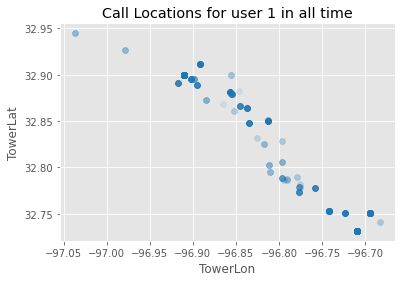

In [13]:
plt.scatter(user1.TowerLon, user1.TowerLat, marker='o', c='#1f77b4', alpha=0.1)
plt.title('Call Locations for user 1 in all time')
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')
plt.show()

INFO: The locations map above should be too "busy" to really wrap your head around. This is where domain expertise comes into play. Your intuition can direct you by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

**5. Add more filters to the `user1` slice you created. Add bitwise logic so that you only examine records that _came in_ on weekends (sat/sun):**

In [14]:
user1['IsWeekend'] = (user1.DOW=='Sat') | (user1.DOW=='Sun')
user1_weekend = user1[user1.IsWeekend==True]
print(BOLD + 'Shape: {}'.format(user1_weekend.shape) + END)
user1_weekend.head()

Shape: (1141, 11)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,IsWeekend
0,4638472273,2666307251,Incoming,2010-12-25,0 days 07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417,True
1,4638472273,1755442610,Incoming,2010-12-25,0 days 21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500,True
2,4638472273,5481755331,Incoming,2010-12-25,0 days 14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,True
3,4638472273,1755442610,Incoming,2010-12-25,0 days 16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,True
4,4638472273,2145623768,Incoming,2010-12-25,0 days 15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389,True


**6. Further filter `user1` down for calls that came in either before 6am OR after 10pm (22:00:00).**

Even if you didn't convert your times from string objects to time deltas, you can still use `<` and `>` to compare the string times as long as you code them as [military time strings](https://en.wikipedia.org/wiki/24-hour_clock), eg: "06:00:00", "22:00:00": 

You may also want to review the Data Manipulation section for this. Once you have your filtered slice, print out its length:

In [15]:
user1_weekend_hometime = user1_weekend[(user1_weekend.CallTime < '06:00:00') | (user1_weekend.CallTime > '22:00:00')]
print(BOLD + 'Shape: {}'.format(user1_weekend_hometime.shape) + END)
user1_weekend_hometime.head()

Shape: (28, 11)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,IsWeekend
940,4638472273,6150928001,Incoming,2011-01-08,0 days 22:22:33.693878,Sat,0:00:35.065912,26f7441e-e64b-4b9d-8c5a-0eb34f7e919f,32.731611,-96.709417,True
1875,4638472273,2145623768,Incoming,2011-01-22,0 days 22:21:27.466908,Sat,0:03:40.018320,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417,True
6949,4638472273,5621270003,Missed,2011-04-09,0 days 22:59:23.206408,Sat,0:03:06.567364,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417,True
7468,4638472273,7756914135,Incoming,2011-04-17,0 days 05:15:40.205917,Sun,0:02:09.984993,cd9f3b1a-2eb8-4cdb-86d1-5d4c2740b1dc,32.731722,-96.709500,True
9753,4638472273,7922223441,Incoming,2011-05-21,0 days 05:08:20.121145,Sat,0:01:30.059591,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417,True


**7. Visualize the dataframe with a scatter plot as a sanity check.**

Since you're [familiar with maps](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude), you know well that your X-Coordinate should be Longitude, and your Y coordinate should be the tower Latitude. Check the dataset headers for proper column feature names.
 
At this point, you don't yet know exactly where the user is located just based on the cell phone tower position data; but considering the below are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence:

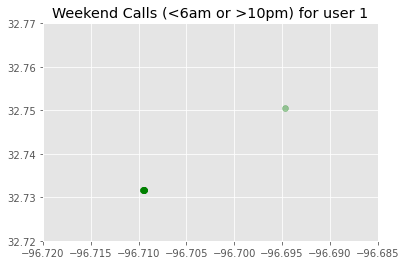

In [16]:
plt.scatter(user1_weekend_hometime.TowerLon, user1_weekend_hometime.TowerLat, marker='o', c='green', alpha=0.2)
plt.title('Weekend Calls (<6am or >10pm) for user 1')
plt.xticks(np.arange(-96.720, -96.680, step=0.005))
plt.yticks(np.arange(32.72, 32.77, step=0.01))
plt.show()

**8. Run K-Means on that dataframe with `K=2` then print out the Cluster Info using clusterInfo function**, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home.....

Be sure to only feed in Lat and Lon coordinates to the KMeans algorithm since none of the other data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale, no feature scaling is required.

In [17]:
model_1_weekend = KMeans(n_clusters=2)
model_1_weekend.fit(user1_weekend_hometime[['TowerLat', 'TowerLon']])
clusterInfo(model_1_weekend)

Cluster Analysis Inertia:  1.1304346153788861e-07
------------------------------------------

  Cluster  0
    Centroid  [ 32.73164942 -96.70944573]
    #Samples  26

  Cluster  1
    Centroid  [ 32.750556 -96.694722]
    #Samples  2


**9. Add centroid locations onto your scatter plot. Use a distinguishable marker and color.**

Hint: Make sure you graph the CORRECT coordinates. This is part of your domain expertise.

In [18]:
centroid_model_1_weekend = pd.DataFrame(model_1_weekend.cluster_centers_, columns=['TowerLat', 'TowerLon'])
centroid_model_1_weekend

,TowerLat,TowerLon
0,32.731649,-96.709446
1,32.750556,-96.694722


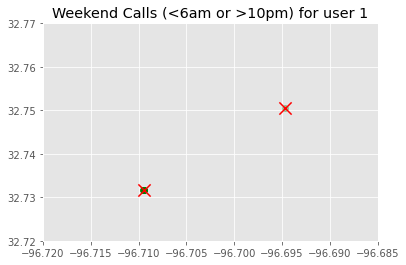

In [19]:
plt.scatter(user1_weekend_hometime.TowerLon, user1_weekend_hometime.TowerLat, marker='o', c='green', alpha=0.2)
plt.scatter(centroid_model_1_weekend.TowerLon, centroid_model_1_weekend.TowerLat, marker='x', c='red', s=150)
plt.title('Weekend Calls (<6am or >10pm) for user 1')
plt.xticks(np.arange(-96.720, -96.680, step=0.005))
plt.yticks(np.arange(32.72, 32.77, step=0.01))
plt.show()

**10. Now that you have a system in place, repeat the above steps (4, 8, and 9) for all 10 individuals in the dataset**. 

You might want to use a for-loop unless you enjoy copying and pasting:

In [20]:
# Number of columns and rows of figure
cols = 3
rows = int(np.ceil(len(list_phones)/cols)) # 4

In [21]:
# Create lists of users data, lists of users data with condition filtering, list of models, and list of centroids of models

list_users = []
list_users_weekend_hometime = []
list_models_weekend = []
list_centroids_weekend = []

for i in range(len(list_phones)):
    # Filter data
    user_x = df[df.In==list_phones[i]]
    user_x_weekend = user_x[(user_x.DOW=='Sat') | (user_x.DOW=='Sun')]
    user_x_weekend_hometime = user_x_weekend[(user_x_weekend.CallTime < '06:00:00') | (user_x_weekend.CallTime > '22:00:00')]
    
    # Create models, train data, find centroids
    model_x_weekend = KMeans(n_clusters=2)
    model_x_weekend.fit(user_x_weekend_hometime[['TowerLat', 'TowerLon']])
    centroid_model_x_weekend = pd.DataFrame(model_x_weekend.cluster_centers_, columns=['TowerLat', 'TowerLon'])
    
    # Adding elements to lists
    list_users.append(user_x)
    list_users_weekend_hometime.append(user_x_weekend_hometime)
    list_models_weekend.append(model_x_weekend)
    list_centroids_weekend.append(centroid_model_x_weekend)

**a. Plot all the call locations for all user in all time:**

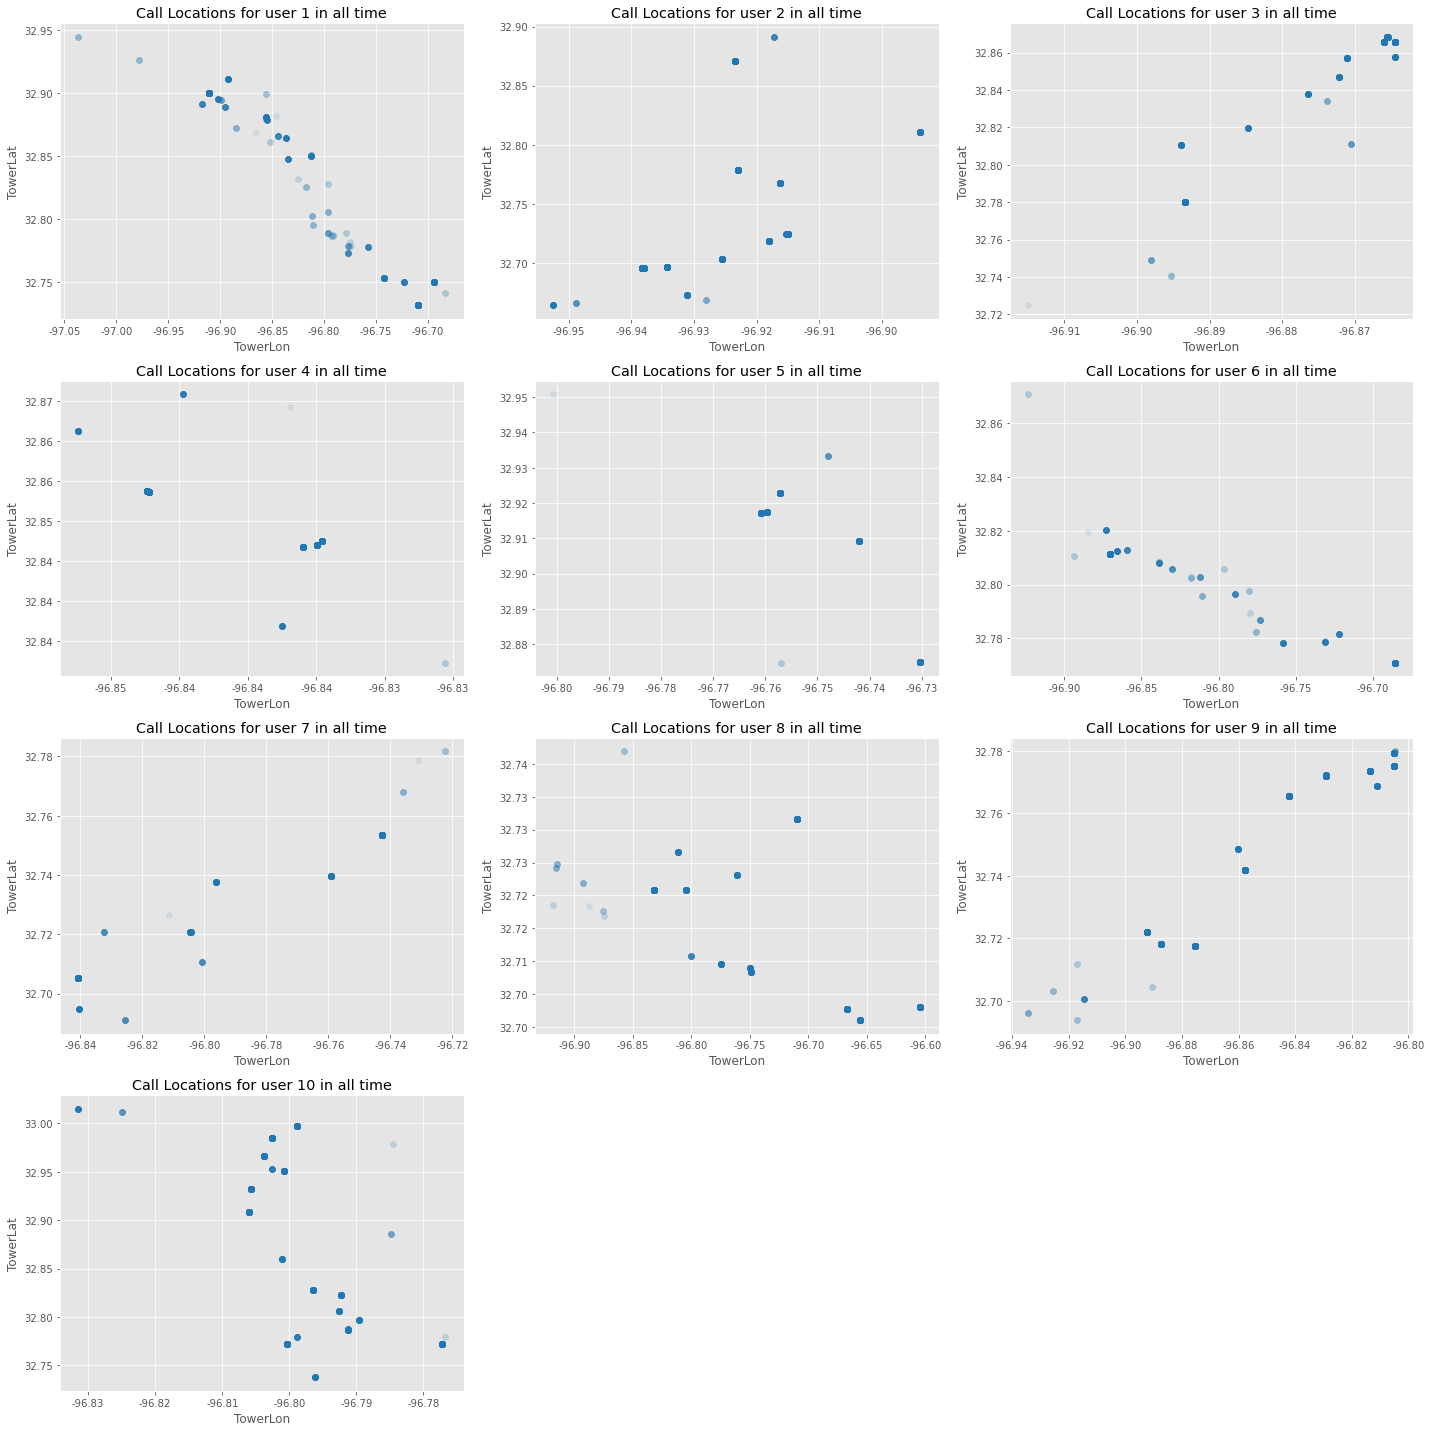

In [22]:
fig_1 = plt.figure(figsize=(20, 20))

for i, user_x in zip(list_index_phones, list_users):
    ax_1 = fig_1.add_subplot(rows, cols, i+1)
    ax_1.scatter(user_x.TowerLon, user_x.TowerLat, marker='o', c='#1f77b4', alpha=0.1)
    ax_1.set_title('Call Locations for user {} in all time'.format(i+1))
    ax_1.set_xlabel('TowerLon')
    ax_1.set_ylabel('TowerLat')
    ax_1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
fig_1.tight_layout()   
plt.show()  

**b. Print out the Cluster Info using clusterInfo function:**

In [23]:
for i, model_x_weekend in zip(list_index_phones, list_models_weekend):
    print(BOLD + 'User {}: {}'.format(i+1, list_phones[i]) + END)
    clusterInfo(model_x_weekend)
    print('\n')

User 1: 4638472273
Cluster Analysis Inertia:  1.1304346153788861e-07
------------------------------------------

  Cluster  0
    Centroid  [ 32.73164942 -96.70944573]
    #Samples  26

  Cluster  1
    Centroid  [ 32.750556 -96.694722]
    #Samples  2


User 2: 1559410755
Cluster Analysis Inertia:  2.1113663366881182e-08
------------------------------------------

  Cluster  0
    Centroid  [ 32.87096756 -96.92355156]
    #Samples  101

  Cluster  1
    Centroid  [ 32.871111 -96.923556]
    #Samples  2


User 3: 4931532174
Cluster Analysis Inertia:  1.9522045272610653e-05
------------------------------------------

  Cluster  0
    Centroid  [ 32.86592718 -96.865298  ]
    #Samples  22

  Cluster  1
    Centroid  [ 32.857778 -96.864444]
    #Samples  1


User 4: 2419930464
Cluster Analysis Inertia:  0.00020962809096294443
------------------------------------------

  Cluster  0
    Centroid  [ 32.84635163 -96.83515822]
    #Samples  27

  Cluster  1
    Centroid  [ 32.861222 -96.85238

**c. Add centroid locations onto your scatter plots (Use a distinguishable marker and color):**

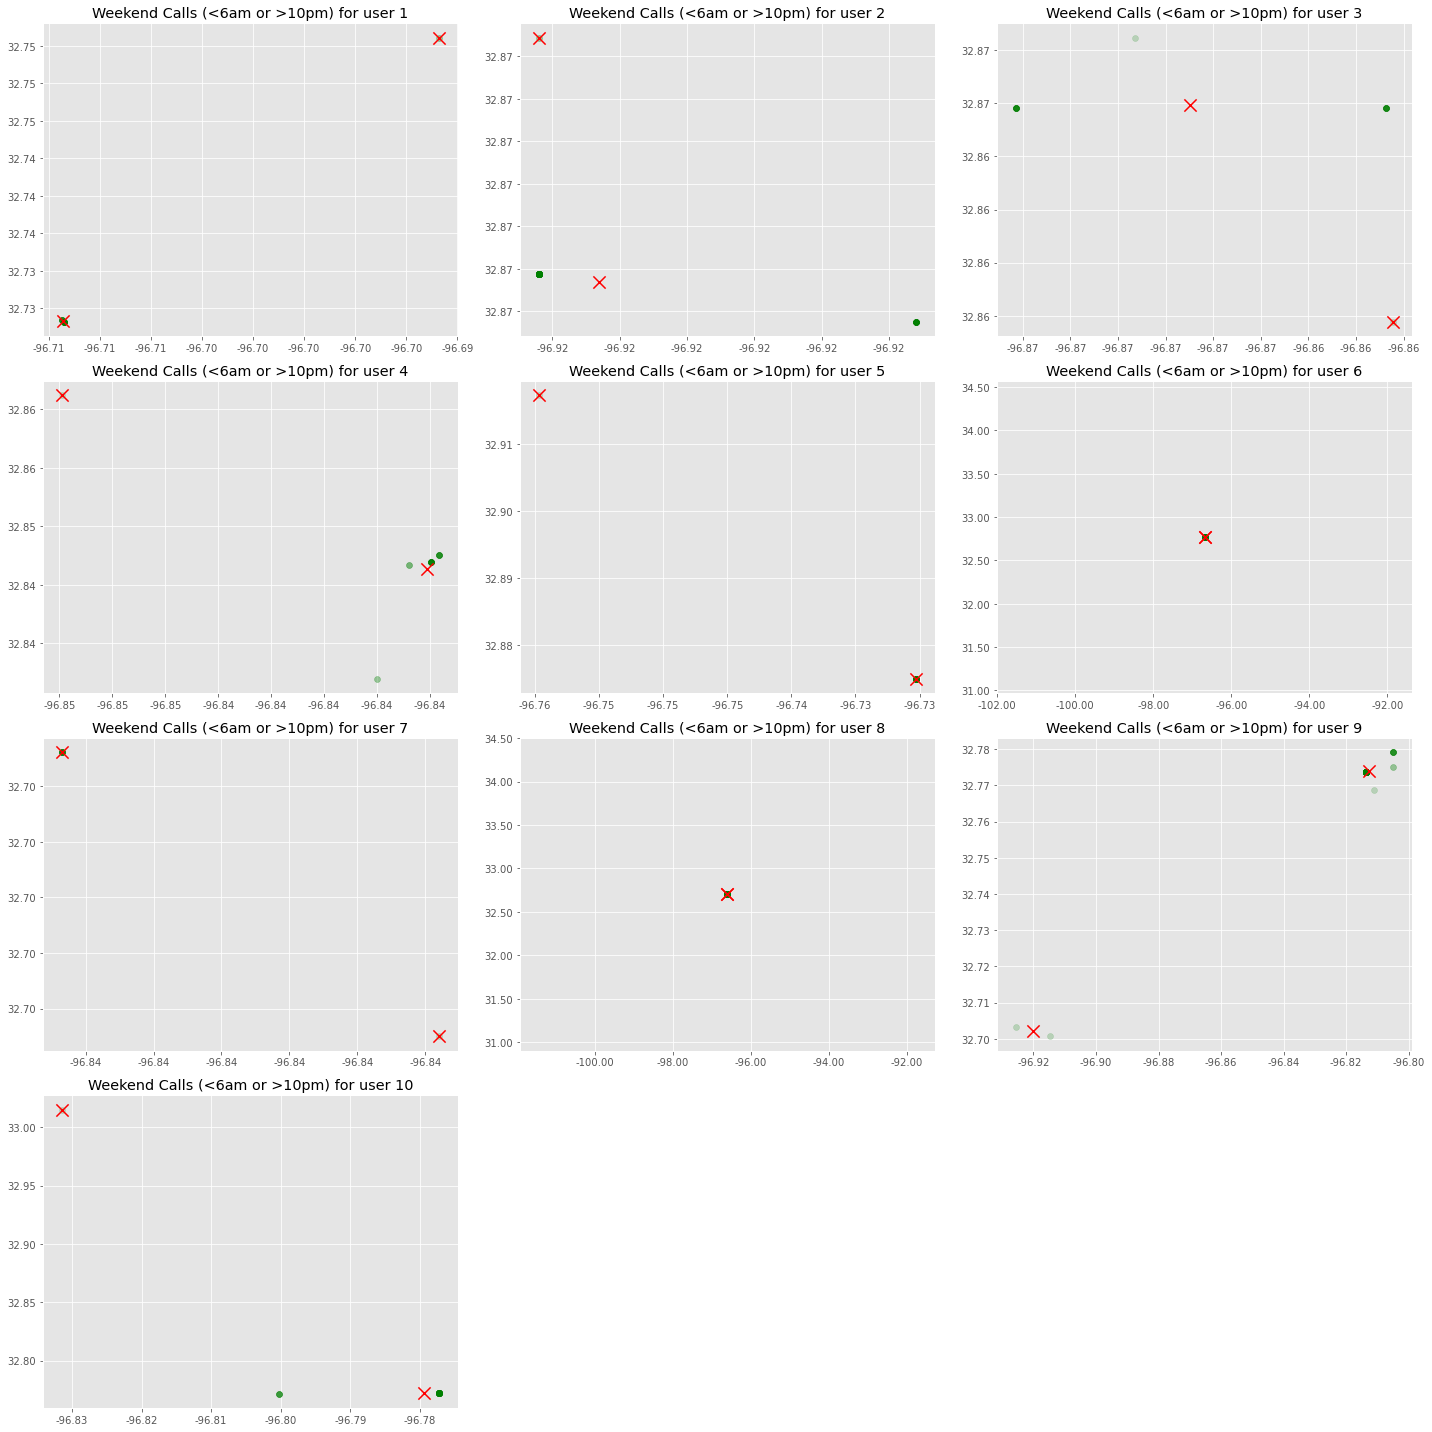

In [24]:
fig_2 = plt.figure(figsize=(20, 20))

for i, user_x_weekend_hometime, centroid_model_x_weekend in zip(list_index_phones, list_users_weekend_hometime, list_centroids_weekend):
    ax_2 = fig_2.add_subplot(rows, cols, i+1)
    ax_2.scatter(user_x_weekend_hometime.TowerLon, user_x_weekend_hometime.TowerLat, marker='o', c='green', alpha=0.2)
    ax_2.scatter(centroid_model_x_weekend.TowerLon, centroid_model_x_weekend.TowerLat, marker='x', c='red', s=150) 
    ax_2.set_title('Weekend Calls (<6am or >10pm) for user {}'.format(i+1))
    ax_2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig_2.tight_layout()
plt.show()

**11. Alter your slice from user1, so that it includes only Weekday (Mon-Fri) values and before 5pm:**

The idea is that the call was placed before 5pm. From Midnight-730a, the user is probably sleeping and won't call/wake up to take a call. There should be a brief time in the morning during their commute to work, then they'll spend the entire day at work. So the assumption is that most of the time is spent either at work or at the second, at home:
        

In [25]:
user1_weekdays_daytime = user1[(user1.IsWeekend==False) & (user1.CallTime < '17:00:00')]
print(BOLD + 'Shape: {}'.format(user1_weekdays_daytime.shape) + END)
user1_weekdays_daytime.head()

Shape: (1405, 11)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,IsWeekend
197,4638472273,5481755331,Incoming,2010-12-28,0 days 16:20:11.532130,Tue,0:03:56.069765,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389,False
200,4638472273,8180005891,Incoming,2010-12-28,0 days 15:27:51.105337,Tue,0:03:30.047757,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389,False
248,4638472273,8180005891,Missed,2010-12-29,0 days 09:13:35.198987,Wed,0:02:10.574446,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389,False
249,4638472273,2145623768,Incoming,2010-12-29,0 days 06:02:11.319738,Wed,0:04:34.436752,9baa92e7-e990-4e9e-8c0a-4c17cb4ecc7c,32.731611,-96.709417,False
250,4638472273,8068555700,Incoming,2010-12-29,0 days 13:54:14.724722,Wed,0:03:31.297111,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,False


**12. Plot the Cell Towers the above data frame:**


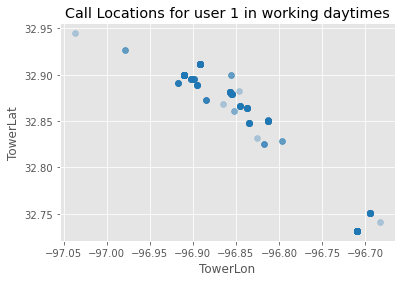

In [26]:
plt.scatter(user1_weekdays_daytime.TowerLon, user1_weekdays_daytime.TowerLat, marker='o', c='#1f77b4', alpha=0.3)
plt.title('Call Locations for user 1 in working daytimes')
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')
plt.show()

**13. Complete the doKmeans function:**

In [27]:
def doKMeans(data, num_clusters=0):
    # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
    # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
    # no feature scaling is required. Print out the centroid locations and add them onto your scatter
    # plot. Use a distinguishable marker and color.
    #
    # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first). This is part
    # of your domain expertise. Also, *YOU* need to create, initialize (and return) the variable named
    # `model` here, which will be a SKLearn K-Means model for this to work:
    
    # .. your code here ..
    data = data.loc[:, ['TowerLat', 'TowerLon']] 
    model = KMeans(n_clusters=num_clusters) 
    model.fit(data)
    
    return model

**14. Let's tun K-Means with `K=3`using doKMeans function for that dataframe (user1 on weekdays in daytime). Then print out the cluster info using clusterInfo function:**

There should only be two areas of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another).

In [28]:
model_1_weekdays = doKMeans(data=user1_weekdays_daytime, num_clusters=3)
clusterInfo(model_1_weekdays)

Cluster Analysis Inertia:  0.1589106952378091
------------------------------------------

  Cluster  0
    Centroid  [ 32.9000009  -96.90951639]
    #Samples  959

  Cluster  1
    Centroid  [ 32.73323174 -96.70816184]
    #Samples  306

  Cluster  2
    Centroid  [ 32.86348712 -96.83818346]
    #Samples  140


**15. Print out the mean `CallTime` value for the samples belonging to the cluster with the LEAST samples attached to it.** 

If our logic is correct, the cluster with the MOST samples will be work. The cluster with the 2nd most samples will be home. And the `K=3` cluster with the least samples should be somewhere in between the two. What time, on average, is the user in between home and work, between midnight and 5pm?

In [29]:
user1_weekdays_daytime['IsFewestSamples'] = clusterWithFewestSamples(model_1_weekdays)
mean_fewest_samples_user1 = user1_weekdays_daytime[user1_weekdays_daytime.IsFewestSamples == True].CallTime.mean()
print('Its Waypoint Time:', mean_fewest_samples_user1, '\n')


Cluster With Fewest Samples:  2
Its Waypoint Time: 0 days 07:49:53.168115942 



**16. Let's visualize the results by drawing the X's for the cluster centers combined with location plot:**


In [30]:
centroid_model_1_weekdays = pd.DataFrame(model_1_weekdays.cluster_centers_, columns=['TowerLat', 'TowerLon'])
centroid_model_1_weekdays

,TowerLat,TowerLon
0,32.900001,-96.909516
1,32.733232,-96.708162
2,32.863487,-96.838183


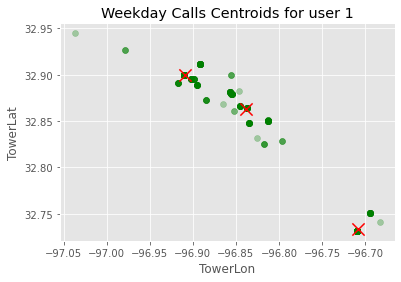

In [31]:
plt.scatter(user1_weekdays_daytime.TowerLon, user1_weekdays_daytime.TowerLat, marker='o', c='green', alpha=0.3)
plt.scatter(centroid_model_1_weekdays.TowerLon, centroid_model_1_weekdays.TowerLat, marker='x', c='red', s=150)
plt.title('Weekday Calls Centroids for user 1')
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')
plt.show()

# Adanved part (15%  of the total score)

**17. Now that you have a system in place, repeat the the steps 12, 14 and 16 for all 10 individuals in the dataset.**

In [32]:
# Add feature 'IsWeekend' (Boolean) to df
df['IsWeekend'] = (df.DOW=='Sat') | (df.DOW=='Sun')
print(BOLD + 'Shape: {}'.format(df.shape) + END)
df.head()

Shape: (53188, 11)


,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon,IsWeekend
0,4638472273,2666307251,Incoming,2010-12-25,0 days 07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417,True
1,4638472273,1755442610,Incoming,2010-12-25,0 days 21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500,True
2,4638472273,5481755331,Incoming,2010-12-25,0 days 14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,True
3,4638472273,1755442610,Incoming,2010-12-25,0 days 16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389,True
4,4638472273,2145623768,Incoming,2010-12-25,0 days 15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389,True


In [33]:
# Create lists of users data with condition filtering, list of models, and list of centroids of models
list_users_weekdays_daytime = []
list_models_weekdays = []
list_centroids_weekdays = []

for i in range(len(list_phones)):
    # Filter data
    user_x = df[df.In==list_phones[i]]
    user_x_weekdays_daytime = user_x[(user_x.IsWeekend==False) & (user_x.CallTime < '17:00:00')]
    
    # Create models, train data, find centroids
    model_x_weekdays = doKMeans(data=user_x_weekdays_daytime, num_clusters=3)
    centroid_model_x_weekdays = pd.DataFrame(model_x_weekdays.cluster_centers_, columns=['TowerLat', 'TowerLon'])
    
    # Adding elements to lists
    list_users_weekdays_daytime.append(user_x_weekdays_daytime)
    list_models_weekdays.append(model_x_weekdays)
    list_centroids_weekdays.append(centroid_model_x_weekdays)

**a. Plot the Cell Towers:**

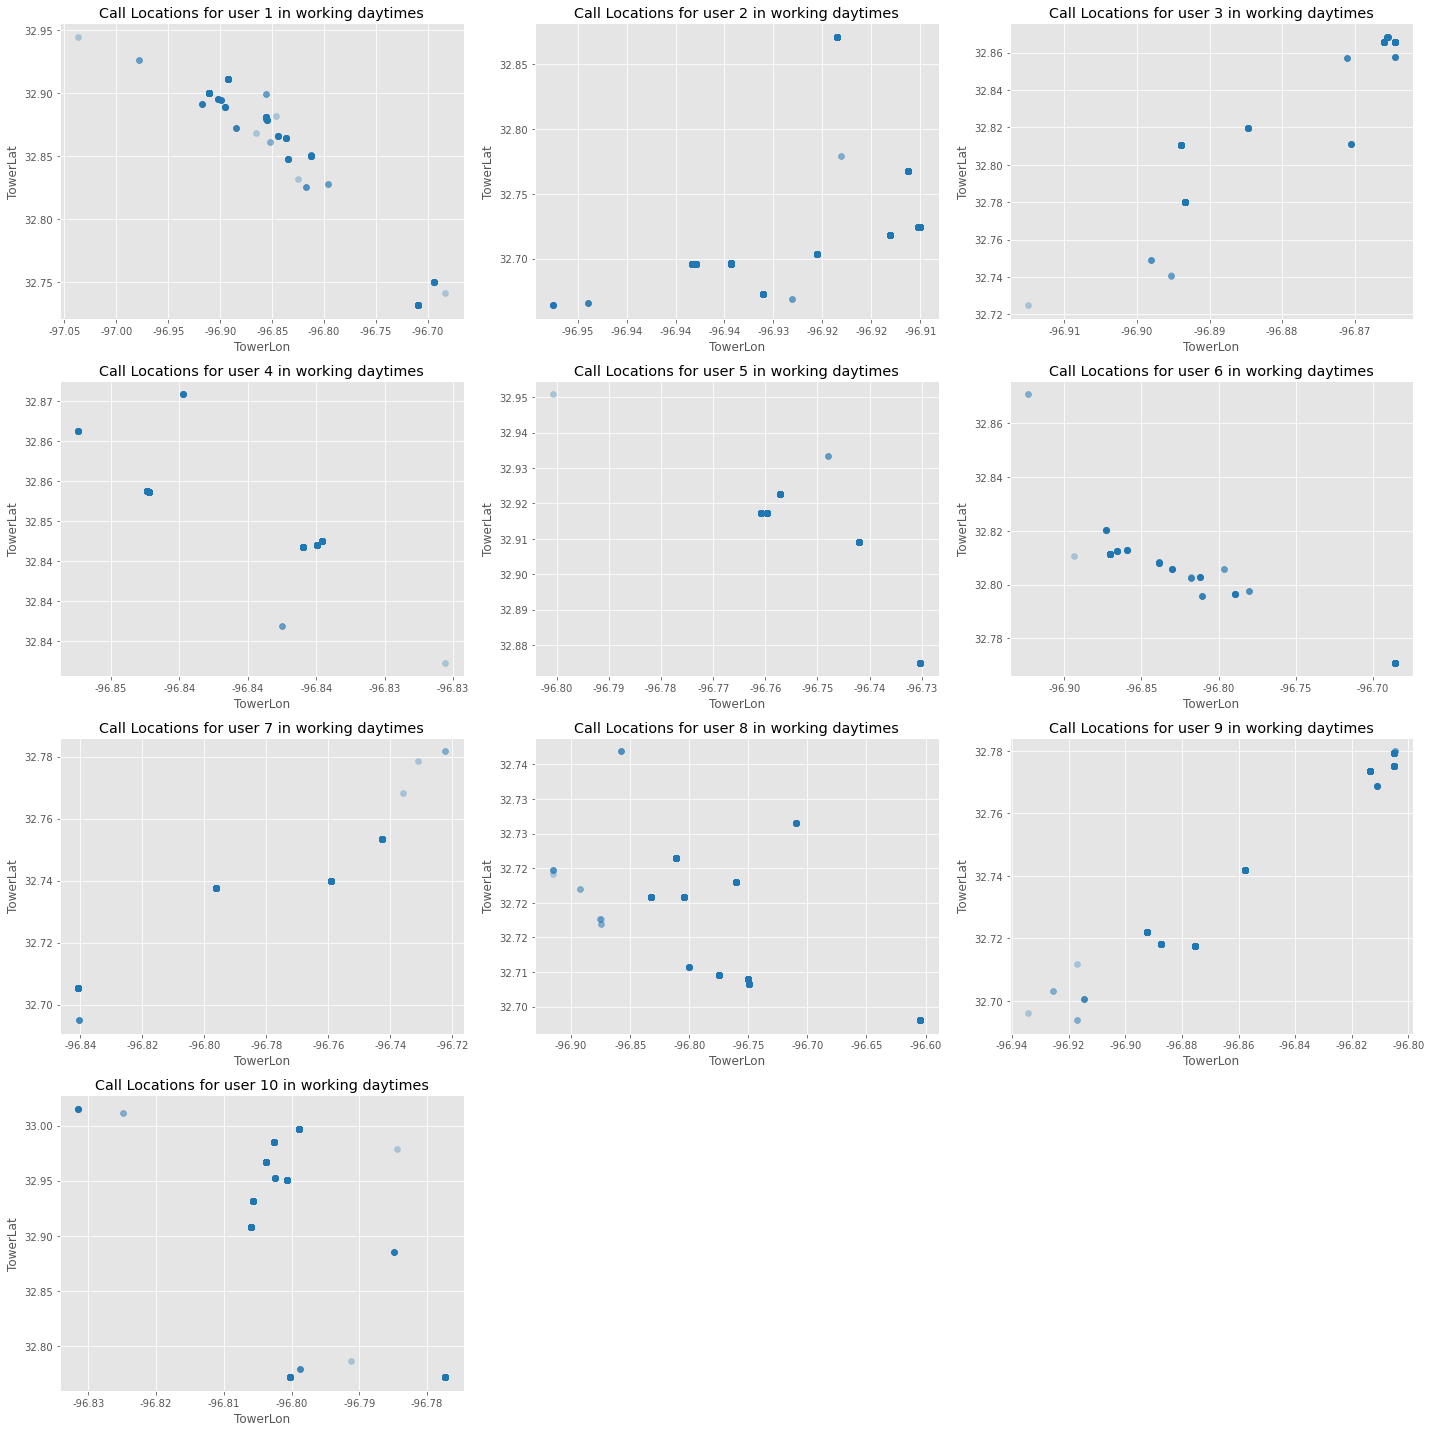

In [34]:
fig_3 = plt.figure(figsize=(20, 20))

for i, user_x_weekdays_daytime in zip(list_index_phones, list_users_weekdays_daytime):
    ax_3 = fig_3.add_subplot(rows, cols, i+1)
    ax_3.scatter(user_x_weekdays_daytime.TowerLon, user_x_weekdays_daytime.TowerLat, marker='o', c='#1f77b4', alpha=0.3)
    ax_3.set_title('Call Locations for user {} in working daytimes'.format(i+1))
    ax_3.set_xlabel('TowerLon')
    ax_3.set_ylabel('TowerLat')
    ax_3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig_3.tight_layout()   
plt.show()  

**b. Print out the cluster info using clusterInfo function:**

In [35]:
for i, model_x_weekdays in zip(list_index_phones, list_models_weekdays):
    print(BOLD + 'User {}: {}'.format(i+1, list_phones[i]) + END)
    clusterInfo(model_x_weekdays)
    print('\n')

User 1: 4638472273
Cluster Analysis Inertia:  0.1589106952378091
------------------------------------------

  Cluster  0
    Centroid  [ 32.73323174 -96.70816184]
    #Samples  306

  Cluster  1
    Centroid  [ 32.9000009  -96.90951639]
    #Samples  959

  Cluster  2
    Centroid  [ 32.86348712 -96.83818346]
    #Samples  140


User 2: 1559410755
Cluster Analysis Inertia:  0.2657446177583027
------------------------------------------

  Cluster  0
    Centroid  [ 32.73762409 -96.9164561 ]
    #Samples  360

  Cluster  1
    Centroid  [ 32.87096795 -96.92355104]
    #Samples  921

  Cluster  2
    Centroid  [ 32.69557708 -96.93522725]
    #Samples  3121


User 3: 4931532174
Cluster Analysis Inertia:  0.0195509698781168
------------------------------------------

  Cluster  0
    Centroid  [ 32.77992299 -96.89338791]
    #Samples  846

  Cluster  1
    Centroid  [ 32.86562866 -96.86563953]
    #Samples  197

  Cluster  2
    Centroid  [ 32.81309497 -96.88911725]
    #Samples  88


User

**c. Visualize the results by drawing the X's for the cluster centers combined with location plot:**

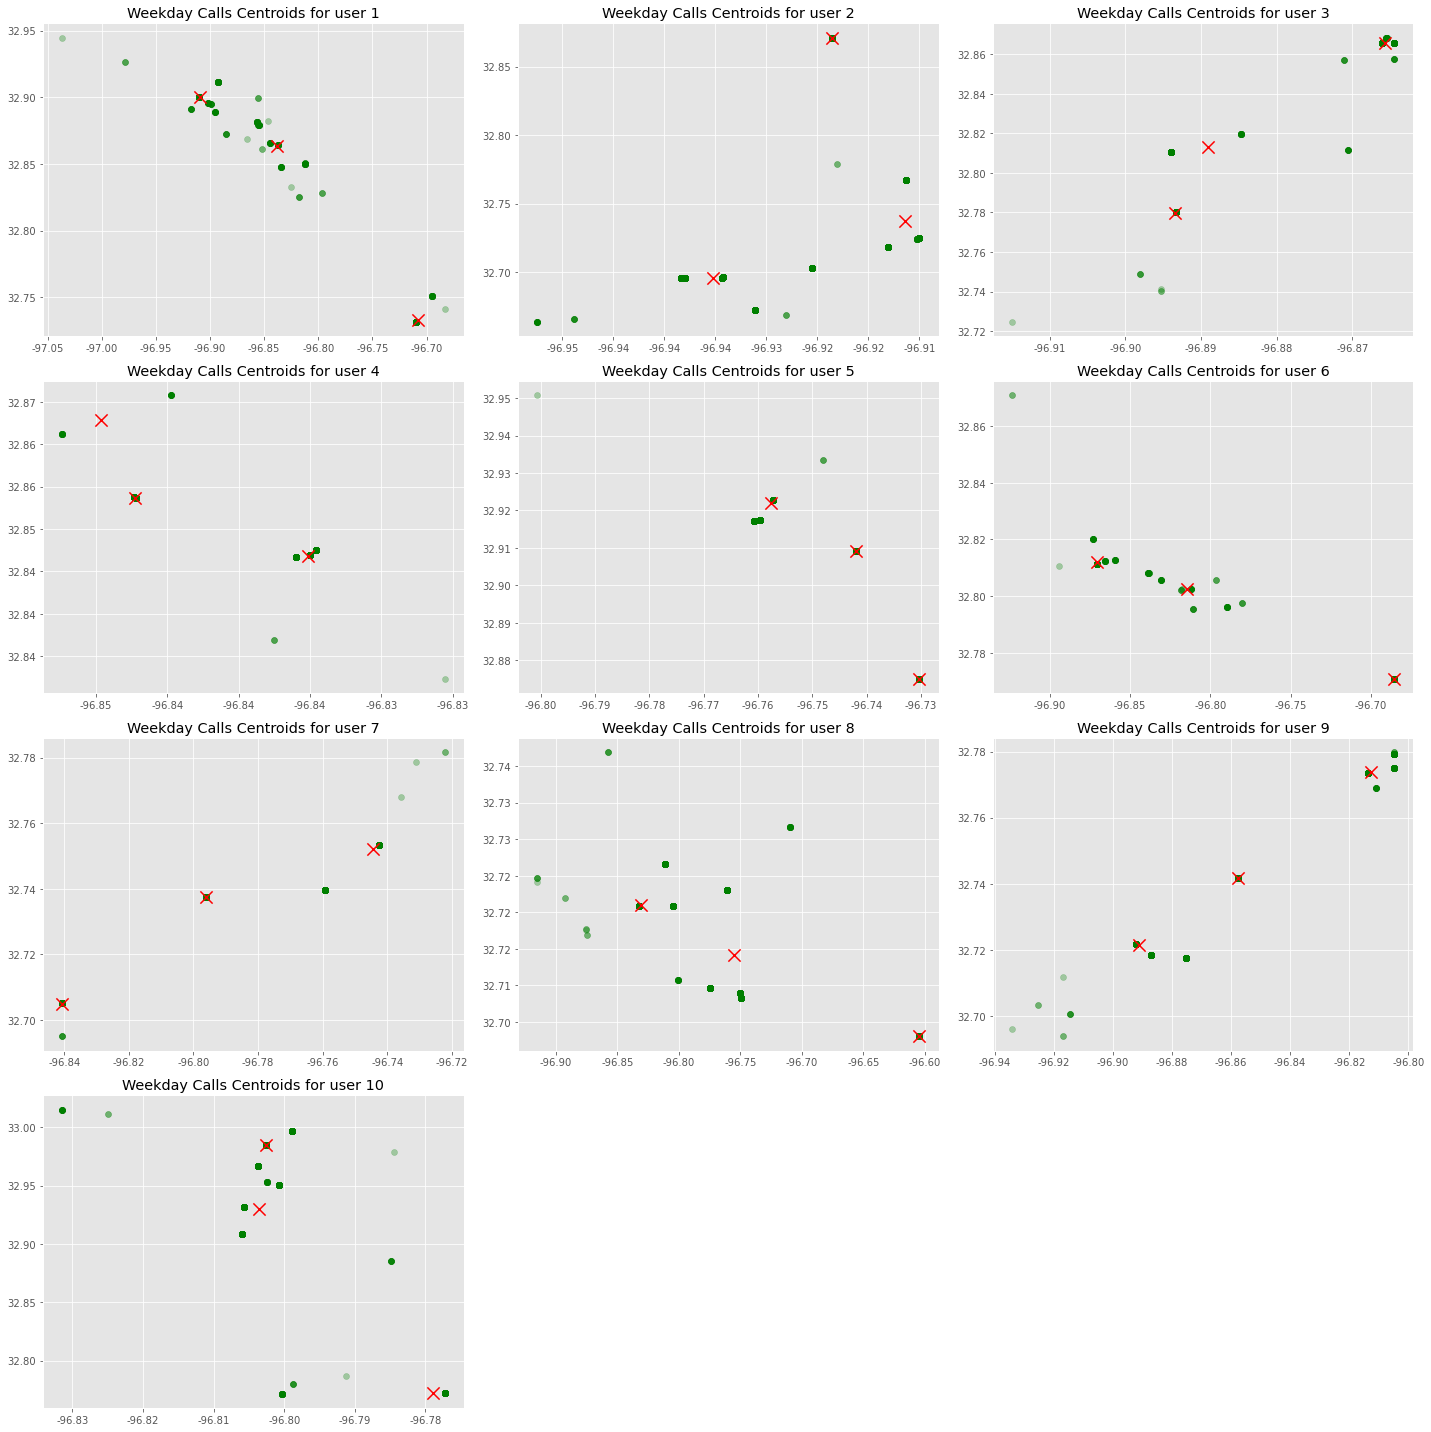

In [36]:
fig_4 = plt.figure(figsize=(20, 20))

for i, user_x_weekdays_daytime, centroid_model_x_weekdays in zip(list_index_phones, list_users_weekdays_daytime, list_centroids_weekdays):
    ax_4 = fig_4.add_subplot(rows, cols, i+1)
    ax_4.scatter(user_x_weekdays_daytime.TowerLon, user_x_weekdays_daytime.TowerLat, marker='o', c='green', alpha=0.3)
    ax_4.scatter(centroid_model_x_weekdays.TowerLon, centroid_model_x_weekdays.TowerLat, marker='x', c='red', s=150) 
    ax_4.set_title('Weekday Calls Centroids for user {}'.format(i+1))
    ax_4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig_4.tight_layout()
plt.show()